# Dataset 1: Mouse Retina
Same technology, same tissues
Batch Effect Cause: Different Laboratories

## Importing Libraries

In [1]:
%%time

# --- General Libraries ---
import os  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns  
from typing import Dict, List, Tuple 

# --- Data Science and Bioinformatics Libraries ---
import anndata  
import scanpy as sc  
from scipy.sparse import csr_matrix  
from scipy.stats import ttest_ind  
from sklearn.preprocessing import scale  
from sklearn.metrics.pairwise import euclidean_distances  
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

# --- Specialized Libraries ---
import pyliger  
from harmony import harmonize

# --- Custom ---
from utils import *  
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import silhouette_score as asw, adjusted_rand_score as ari
from sklearn.metrics import silhouette_score
from lisi import *
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
from combat.pycombat import pycombat

C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument 

CPU times: total: 8.58 s
Wall time: 28.5 s


In [2]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.

    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.

    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels[cell_neighbors]
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score

from sklearn.metrics import silhouette_score
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    embeddings = data[embeddings_columns].values  # Get the embedding coordinates
    labels = data[labels_column].values  # Get the labels
    asw_score = silhouette_score(embeddings, labels)  # Calculate silhouette score
    return asw_score

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
def compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw):
    """
    Computes and prints various metrics for a given embedding and metadata.

    Parameters:
    embedding (pd.DataFrame): DataFrame containing embedding coordinates.
    metadata (pd.DataFrame): DataFrame containing metadata (e.g., batch, cell type).
    compute_lisi (function): Function to compute LISI scores.
    calculate_kbet (function): Function to calculate kBET scores.
    calculate_asw (function): Function to calculate ASW scores.

    Returns:
    None
    """
    import time

    start_time = time.time()

    # Convert to a DataFrame for alignment with metadata
    embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

    # Ensure metadata categories
    metadata['batch'] = metadata['batch'].astype('category')
    metadata['CellType'] = metadata['CellType'].astype('category')

    # Compute LISI scores
    label_colnames = ["batch", "CellType"]
    lisi_scores = compute_lisi(
        X=embedding[["tsne1", "tsne2"]].values,
        metadata=metadata,
        label_colnames=label_colnames,
        perplexity=30
    )

    # Separate LISI scores
    lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
    lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

    # Print LISI results
    print("Batch Mean LISI Scores:", lisi_batch.mean())
    print("Batch Median LISI Scores:", np.median(lisi_batch))
    print("Celltype Mean LISI Scores:", lisi_celltype.mean())
    print("Celltype Median LISI Scores:", np.median(lisi_celltype))

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=20)
    print(f"kBET score 20: {kbet_score}")
    
    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=30)
    print(f"kBET score 30: {kbet_score}")

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=40)
    print(f"kBET score 40: {kbet_score}")

    # Compute ASW scores
    embedding_columns = ['tsne1', 'tsne2']
    embedding_df['CellType'] = metadata['CellType'].astype('category')
    embedding['CellType'] = embedding_df.reset_index()['CellType']
    
    # Calculate ASW for CellType
    asw_celltype = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='CellType')
    print(f"ASW (CellType): {asw_celltype}")

    # Calculate ASW for batches (datasets)
    asw_batch = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='Dataset')
    print(f"ASW (Batch): {asw_batch}")

    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")

## Importing Dataset

In [4]:
%%time

# Directory
read_dir = r"C:/Users/namra/Emlyon/30 Master's Thesis/data/dataset_mouse retina"

# Filenames
b1_exprs_filename = "b1_exprs.txt"
b2_exprs_filename = "b2_exprs.txt"
b1_celltype_filename = "b1_celltype.txt"
b2_celltype_filename = "b2_celltype.txt"

batch_label = "batchlb"
celltype_label = "CellType"

batch_label = "batchlb"
celltype_label = "CellType"

# Reading data
b1_exprs = pd.read_csv(os.path.join(read_dir, b1_exprs_filename), sep="\t", header=0, index_col=0)
b2_exprs = pd.read_csv(os.path.join(read_dir, b2_exprs_filename), sep="\t", header=0, index_col=0)
b1_celltype = pd.read_csv(os.path.join(read_dir, b1_celltype_filename), sep="\t", header=0, index_col=0)
b2_celltype = pd.read_csv(os.path.join(read_dir, b2_celltype_filename), sep="\t", header=0, index_col=0)

# Aligning metadata with expression matrices
b1_celltype['cell'] = b1_celltype.index
b1_celltype = b1_celltype.loc[b1_exprs.columns]
b2_celltype['cell'] = b2_celltype.index
b2_celltype = b2_celltype.loc[b2_exprs.columns]

# Preparing metadata and assigning batch labels
b1_metadata = b1_celltype.copy()
b2_metadata = b2_celltype.copy()
b1_metadata['batch'] = 1
b2_metadata['batch'] = 2
b1_metadata[batch_label] = 'Batch_1'
b2_metadata[batch_label] = 'Batch_2'

# Combining expression matrices and metadata
expr_mat = pd.concat([b1_exprs, b2_exprs], axis=1)
metadata = pd.concat([b1_metadata, b2_metadata], axis=0)

# Ensure column alignment between expr_mat and metadata
expr_mat = expr_mat.loc[:, metadata.index]

# EDA: Quick Summary
print(f"Expression Matrix Shape: {expr_mat.shape}")
print(f"Metadata Shape: {metadata.shape}")

Expression Matrix Shape: (12333, 71638)
Metadata Shape: (71638, 4)
CPU times: total: 6min 41s
Wall time: 10min 45s


In [3]:
%%time

print("\nCell Type Distribution:")
display(metadata['CellType'].value_counts())
    
print("\nBatch Distribution:")
display(metadata['batch'].value_counts())


Cell Type Distribution:


CellType
bipolar                 29779
rods                    29491
amacrine                 4678
muller                   4569
cones                    1916
ganglion                  432
vascular_endothelium      252
horizontal                252
fibroblasts                85
microglia                  67
pericytes                  63
astrocytes                 54
Name: count, dtype: int64


Batch Distribution:


batch
2    44808
1    26830
Name: count, dtype: int64

CPU times: total: 0 ns
Wall time: 117 ms


In [4]:
%%time

# Check the resulting expression matrix and metadata
display(expr_mat.head())
display(metadata.head())

,Bipolar1_CCCACAAGACTA,Bipolar1_CAAAGCATTTGC,Bipolar1_CTTTTGATTGAC,Bipolar1_GCTCCAATGACA,Bipolar1_AAATACCCTCAT,Bipolar1_TGCATGCGTCCA,Bipolar1_TTCCGGCTTTTC,Bipolar1_CAACGTATCCTT,Bipolar1_CATCGAACGACG,Bipolar1_ACCGGAAGTCCA,...,r6_TTTTCTTATCTG,r6_TTTTGCAGTGTT,r6_TTTTGCGGGCGG,r6_TTTTGGAGTCTG,r6_TTTTGTTTCAGA,r6_TTTTTACCTGAT,r6_TTTTTCGAGCGT,r6_TTTTTGCAGTGA,r6_TTTTTGTCTACG,r6_TTTTTTGCTCAA
0610007P14Rik,0,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,2,1,0,0
0610009E02Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009O20Rik,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,CellType,cell,batch,batchlb
Bipolar1_CCCACAAGACTA,bipolar,Bipolar1_CCCACAAGACTA,1,Batch_1
Bipolar1_CAAAGCATTTGC,bipolar,Bipolar1_CAAAGCATTTGC,1,Batch_1
Bipolar1_CTTTTGATTGAC,bipolar,Bipolar1_CTTTTGATTGAC,1,Batch_1
Bipolar1_GCTCCAATGACA,bipolar,Bipolar1_GCTCCAATGACA,1,Batch_1
Bipolar1_AAATACCCTCAT,bipolar,Bipolar1_AAATACCCTCAT,1,Batch_1


CPU times: total: 0 ns
Wall time: 67.9 ms


## Exploratory Data Analysis

<timed exec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



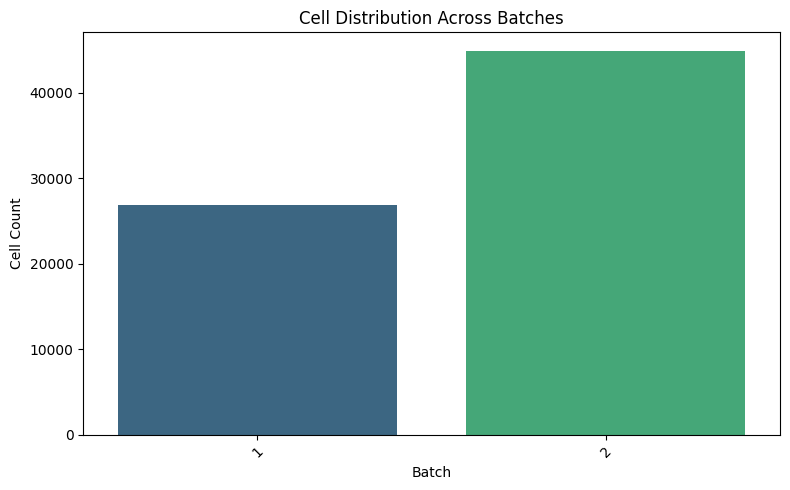

CPU times: total: 15.6 ms
Wall time: 161 ms


In [7]:
%%time

# EDA: Distribution of cells per batch
plt.figure(figsize=(8, 5))
sns.countplot(data=metadata, x='batch', palette="viridis")
plt.title("Cell Distribution Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

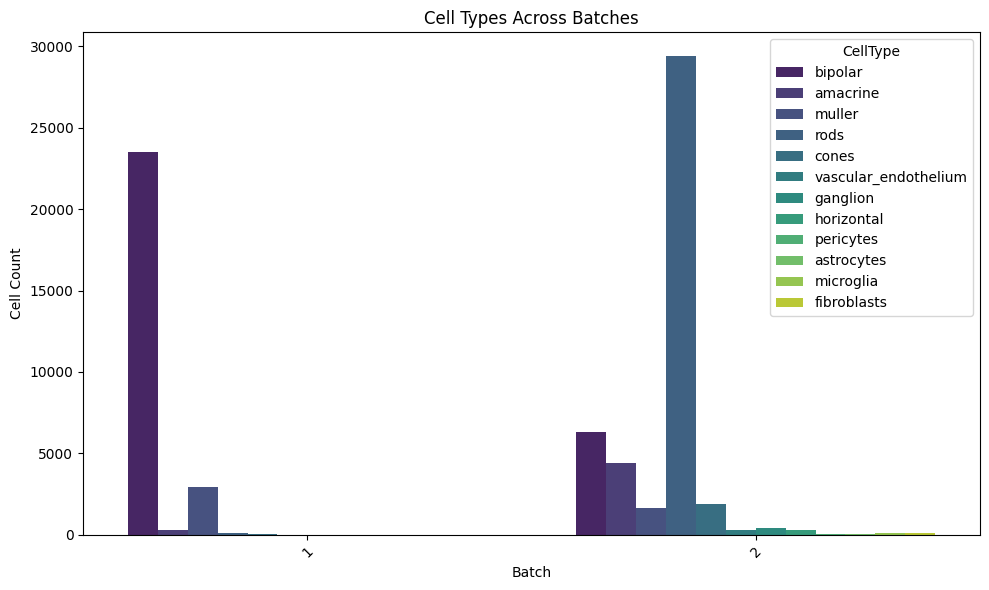

CPU times: total: 141 ms
Wall time: 288 ms


In [8]:
%%time

# EDA: Cell types per batch
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='batch', hue='CellType', palette="viridis")
plt.title("Cell Types Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

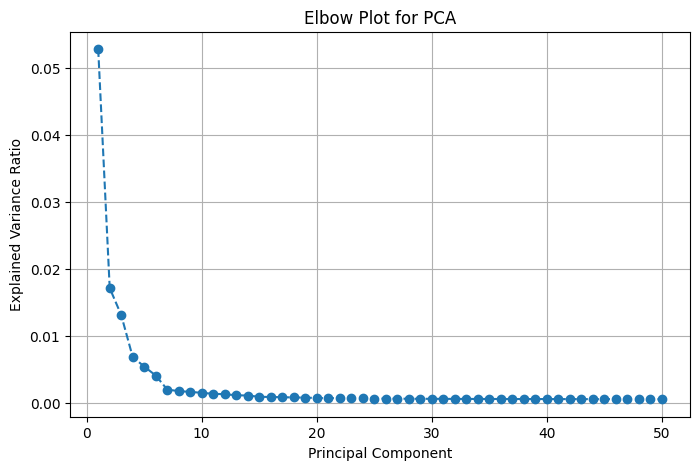

In [4]:
# Create AnnData object
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize and log transform data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Compute PCA with more components to check explained variance
sc.tl.pca(adata, svd_solver='arpack')

# Plot the explained variance ratio
explained_variance_ratio = adata.uns['pca']['variance_ratio']

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()

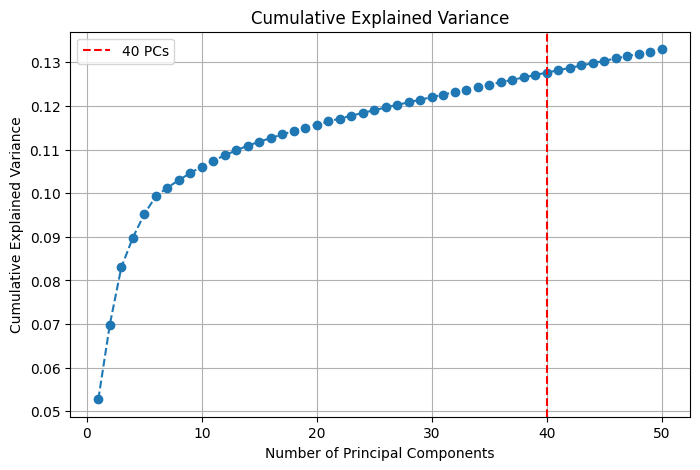

Variance explained by first 50 PCs: 13.30%
Variance explained by first 40 PCs: 12.76%
Variance explained by first 30 PCs: 12.20%
Variance explained by first 20 PCs: 11.57%
Variance explained by first 10 PCs: 10.61%


In [5]:
# Cumulative explained variance
cumulative_variance = np.cumsum(adata.uns['pca']['variance_ratio'])

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(40, color='r', linestyle='--', label='40 PCs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.savefig("cumulative_variance_plot.png")
plt.show()

# Print explained variance captured by 40 PCs
print(f"Variance explained by first 50 PCs: {cumulative_variance[49]:.2%}")
print(f"Variance explained by first 40 PCs: {cumulative_variance[39]:.2%}")
print(f"Variance explained by first 30 PCs: {cumulative_variance[29]:.2%}")
print(f"Variance explained by first 20 PCs: {cumulative_variance[19]:.2%}")
print(f"Variance explained by first 10 PCs: {cumulative_variance[9]:.2%}")

### Batch Effects Analysis

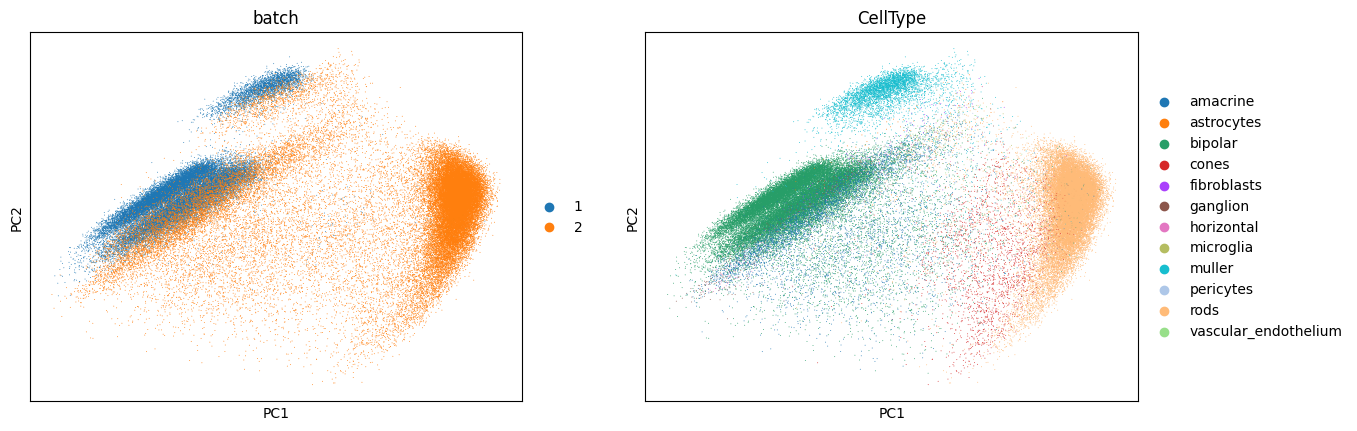

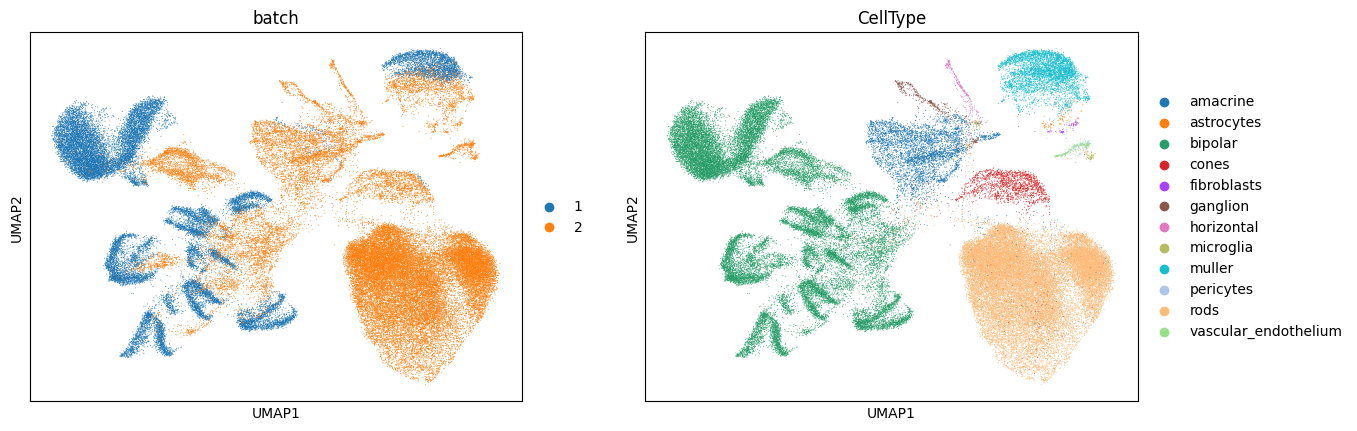

CPU times: total: 12min 2s
Wall time: 2min 38s


In [6]:
%%time

# Prepare data for scanpy AnnData
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize & log transform data 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs['batch'] = adata.obs['batch'].astype('category')

# Run PCA & UMAP for batch visualization
sc.tl.pca(adata)
sc.pl.pca(adata, color=['batch', 'CellType'])

# Running UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'CellType'])

In [12]:
%%time

batches = adata.obs['batch'].unique()

batch_data = {batch: adata[adata.obs['batch'] == batch].X.toarray() for batch in batches}

# Perform statistical tests (t-test) for each gene across batches
gene_pvals = []
for gene_idx in range(adata.shape[1]):  
    batch_exprs = [batch_data[batch][:, gene_idx] for batch in batches]
    if len(batch_exprs) == 2:
        # performing t test
        _, pval = ttest_ind(batch_exprs[0], batch_exprs[1], equal_var=False)
    else:
        # Perform ANOVA or other tests if >2 batches
        raise NotImplementedError("Extend for >2 batches if needed.")
    gene_pvals.append(pval)

results_df = pd.DataFrame({
    "gene": adata.var_names,  # Gene names
    "p_value": gene_pvals
})

results_df['adjusted_p_value'] = results_df['p_value'] * len(results_df)
results_df['adjusted_p_value'] = results_df['adjusted_p_value'].clip(upper=1.0)
significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]
print(f"Number of significant genes: {len(significant_genes)}")
print(significant_genes)

# Batch-to-batch distance
batch_means = {batch: np.mean(batch_data[batch], axis=0) for batch in batches}
batch_distances = euclidean_distances(list(batch_means.values()))

# Print the distances
print("Batch-to-batch distances (Euclidean):")
batch_distance_df = pd.DataFrame(
    batch_distances, 
    index=batches, 
    columns=batches
)
print(batch_distance_df)

Number of significant genes: 8341
                gene       p_value  adjusted_p_value
0      0610007P14Rik  1.793618e-25      2.212069e-21
5      0610010F05Rik  5.403696e-08      6.664378e-04
6      0610030E20Rik  4.634111e-14      5.715249e-10
7      0610037L13Rik  1.966398e-63      2.425159e-59
8      0610040B10Rik  2.182837e-21      2.692093e-17
...              ...           ...               ...
12323          mt-Tc  1.213371e-14      1.496450e-10
12326          mt-Tp  4.175488e-34      5.149629e-30
12329          mt-Tt  6.320788e-12      7.795428e-08
12330          mt-Tv  6.619920e-07      8.164347e-03
12331          mt-Tw  8.728474e-48      1.076483e-43

[8341 rows x 3 columns]
Batch-to-batch distances (Euclidean):
           1          2
1   0.000000  21.464272
2  21.464272   0.000000
CPU times: total: 37 s
Wall time: 37.9 s


## LIGER
https://github.com/welch-lab/pyliger/blob/master/integrating_multi_scRNA_data.ipynb

In [5]:
%%time

batch_label='batchlb'
celltype_label='CellType' 

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    adata.uns['sample_name'] = batch   

    adata_list.append(adata)

CPU times: total: 10.7 s
Wall time: 33.1 s


100%|██████████| 30/30 [10:37<00:00, 21.25s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


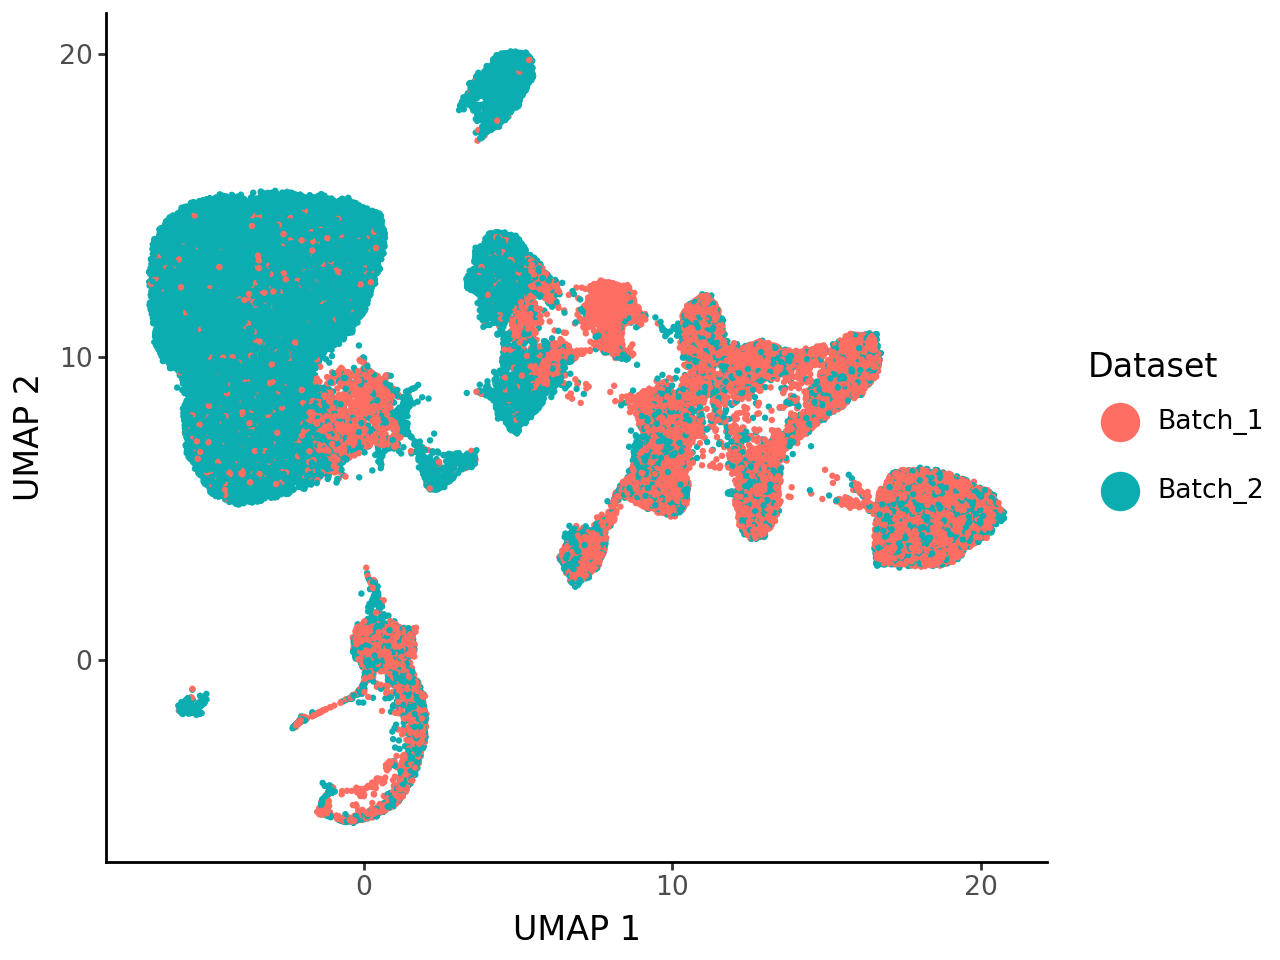

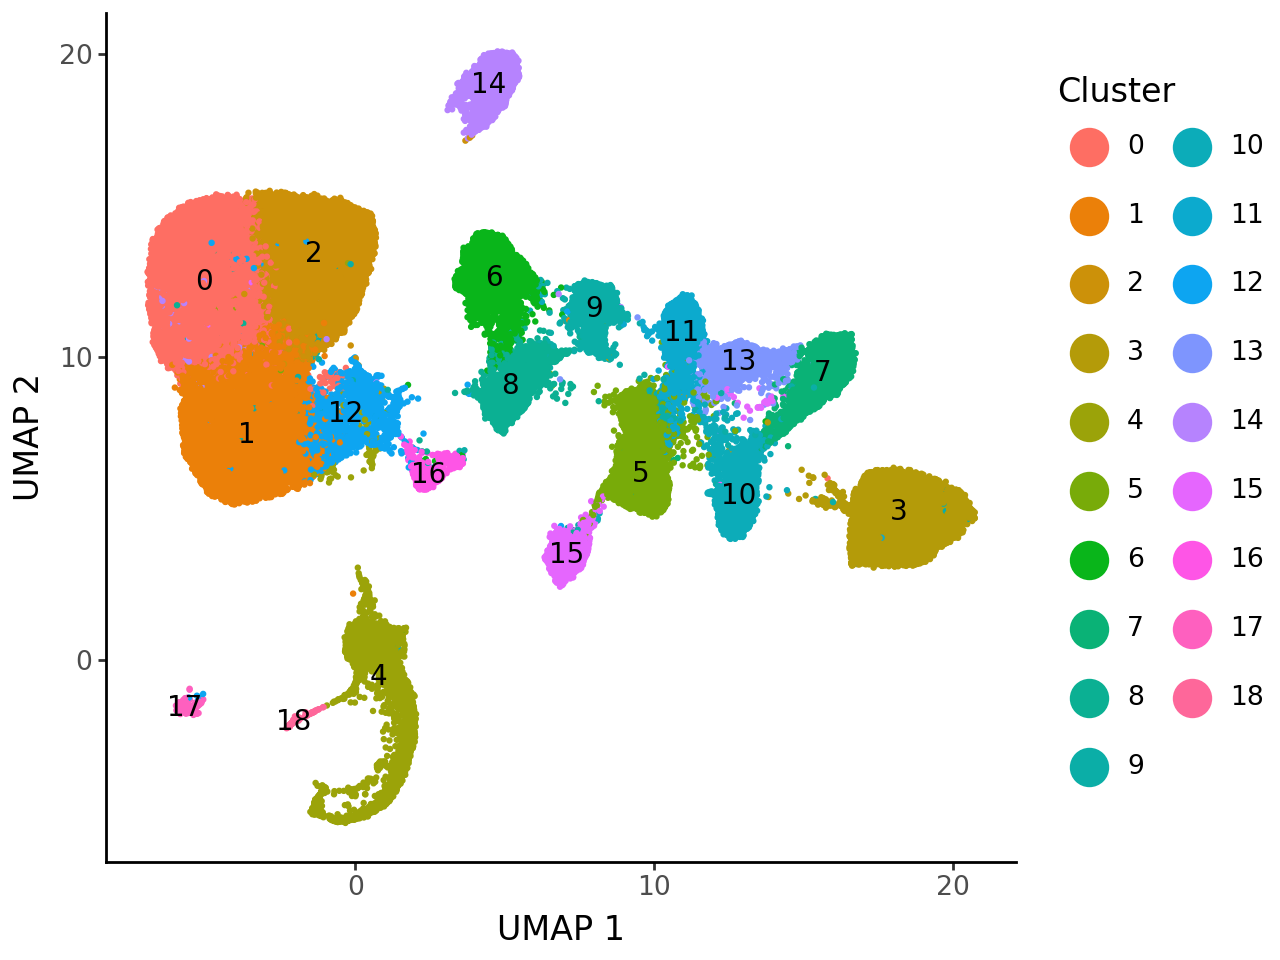

Performing Wilcoxon test on ALL datasets: Batch_1, Batch_2
CPU times: total: 33min 12s
Wall time: 16min 51s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [11]:
%%time

k=20
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [17]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.3380477510080364
Batch Median LISI Scores: 1.221466141370691
Celltype Mean LISI Scores: 1.1247242190242375
Celltype Median LISI Scores: 1.0238905832140328
kBET score 20: 0.7887538736424802
kBET score 30: 0.7843663046613994
kBET score 40: 0.7818640246796392
ASW (CellType): 0.1938784122467041
ASW (Batch): 0.2640485465526581
Execution Time: 181.65386652946472 seconds


Removing 1 genes not expressing in Batch_2.
Index(['Gm21887'], dtype='object', name='gene_names')


100%|██████████| 30/30 [18:32<00:00, 37.08s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


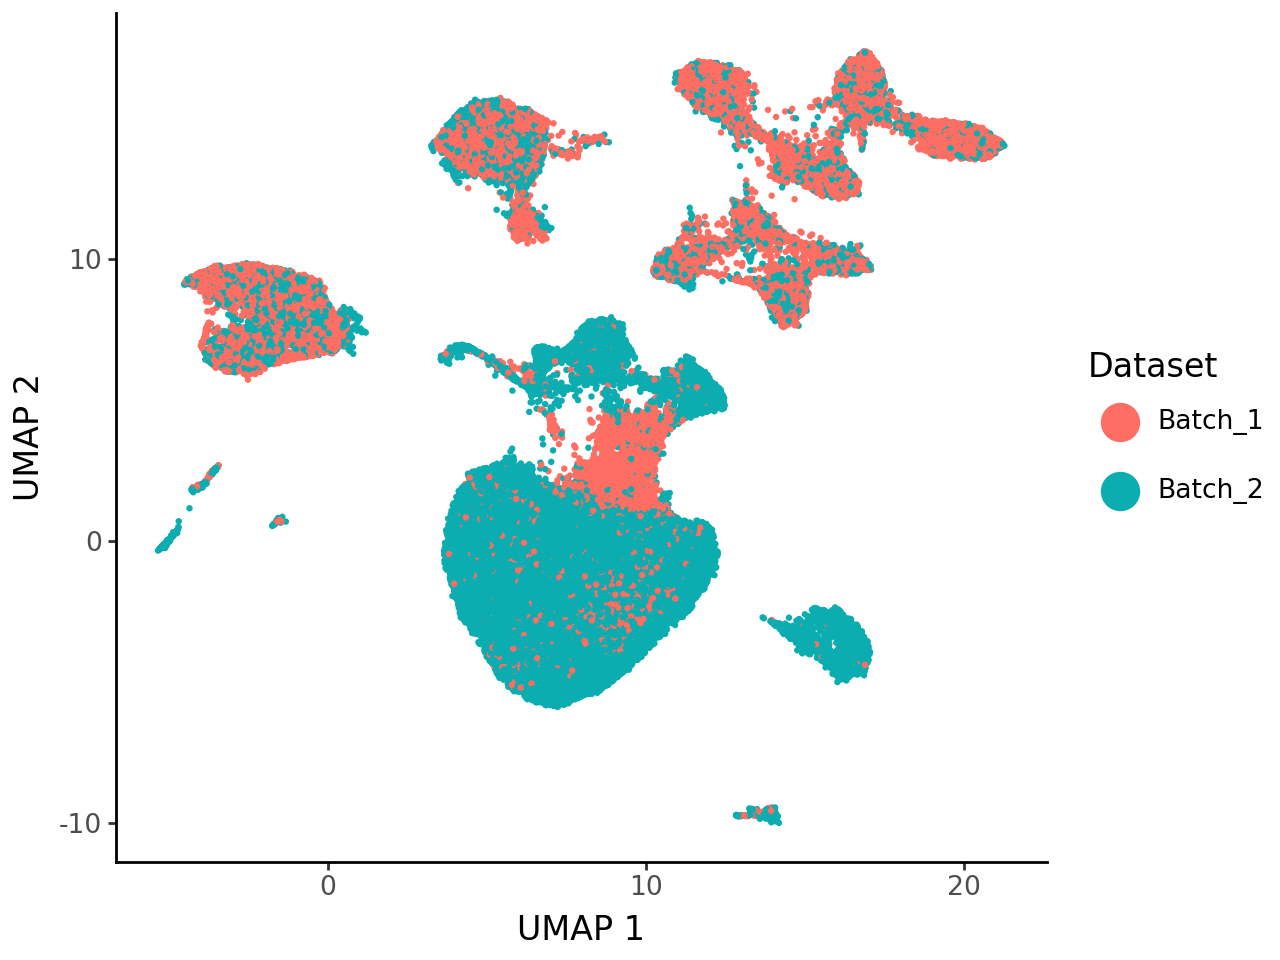

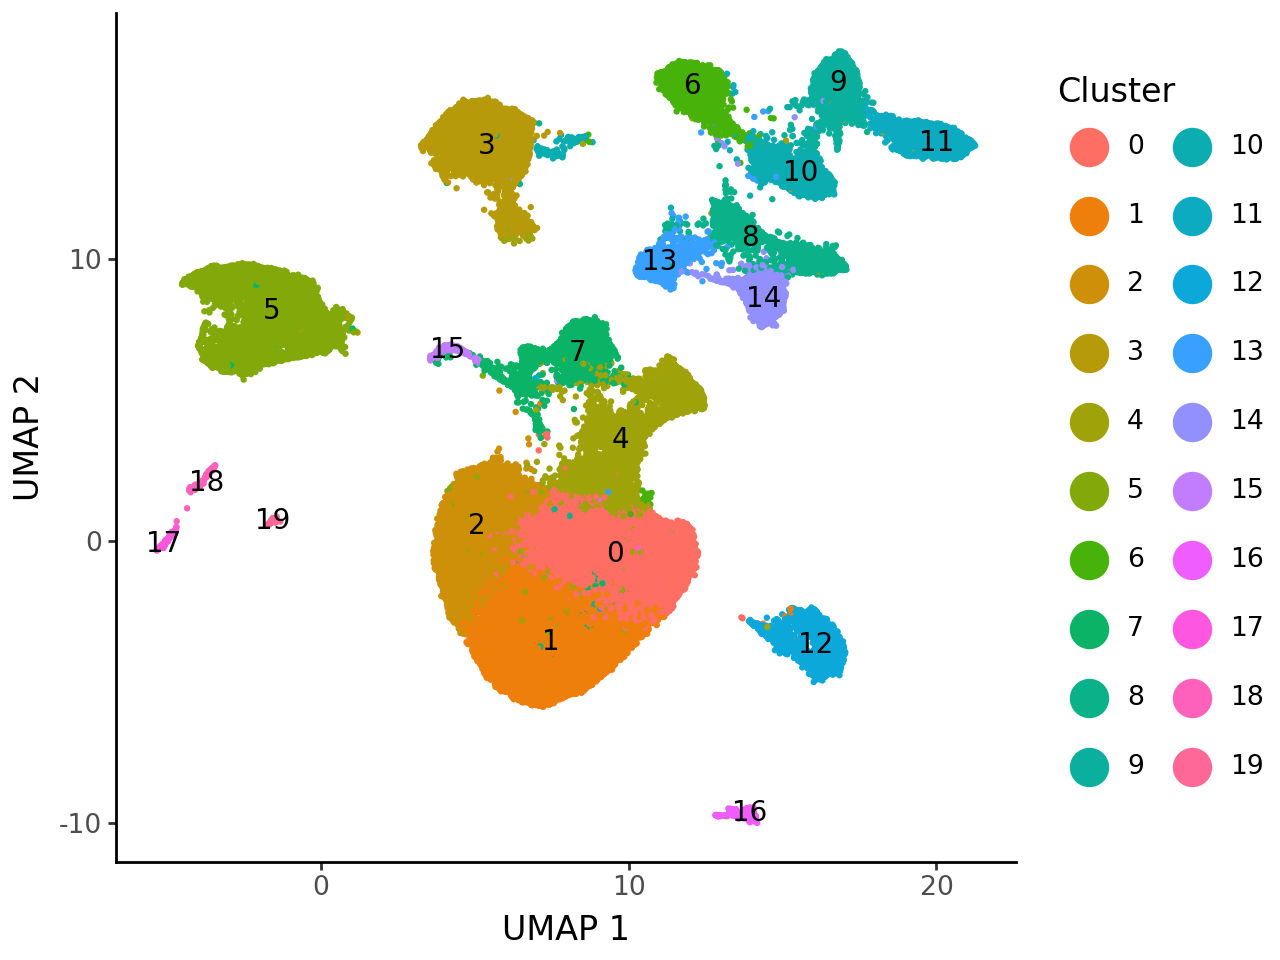

Performing Wilcoxon test on ALL datasets: Batch_1, Batch_2
CPU times: total: 41min 4s
Wall time: 30min 42s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [6]:
%%time

k=30
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [7]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.3520118687130183
Batch Median LISI Scores: 1.2486847991713266
Celltype Mean LISI Scores: 1.1386943940992555
Celltype Median LISI Scores: 1.0330730918205164
kBET score 20: 0.7788485161506463
kBET score 30: 0.7747112798607816
kBET score 40: 0.7723449845054302
ASW (CellType): 0.1913188397884369
ASW (Batch): 0.22719617187976837
Execution Time: 183.33776021003723 seconds


100%|██████████| 30/30 [08:38<00:00, 17.27s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


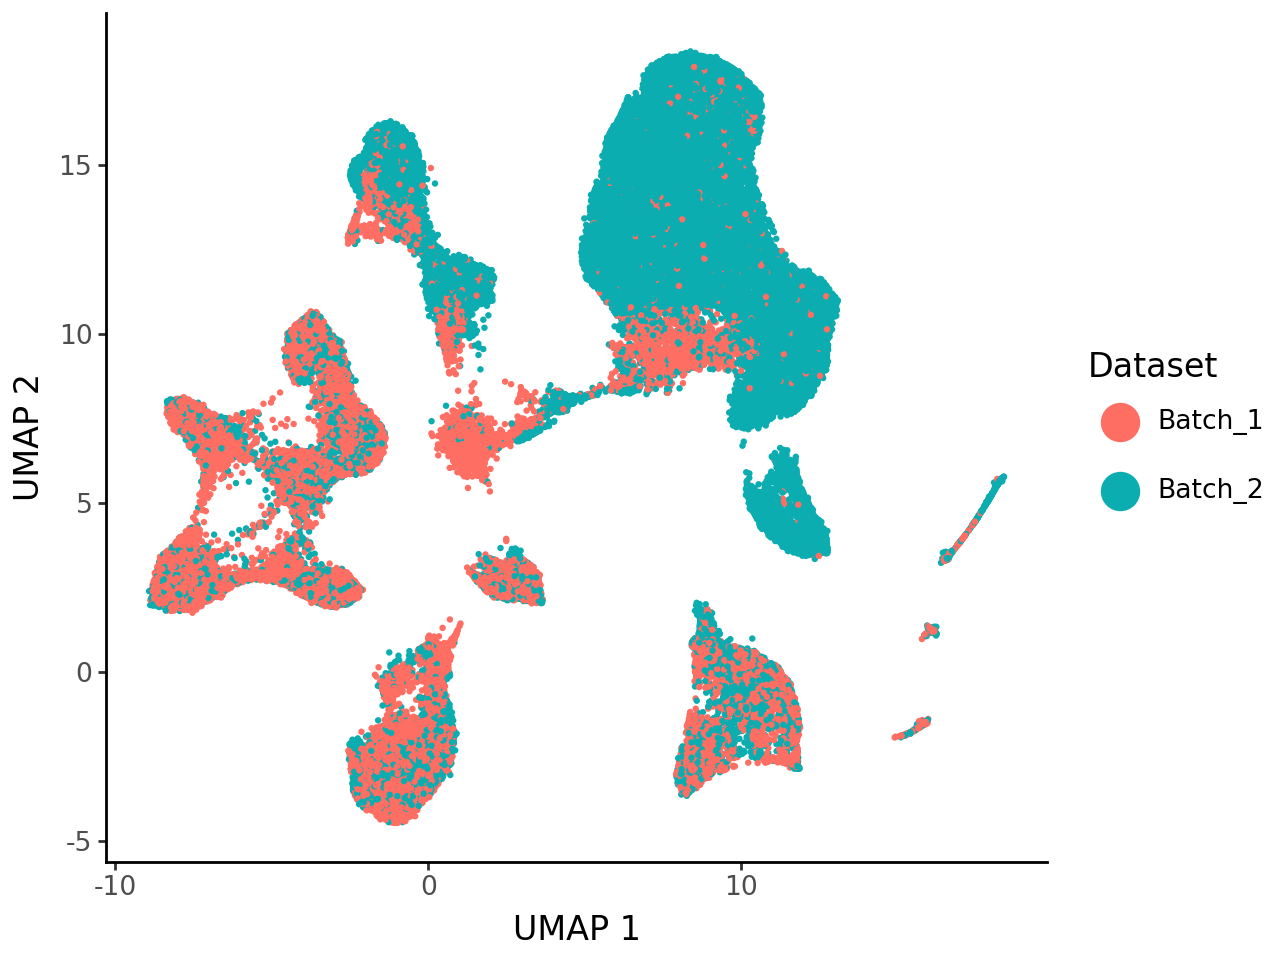

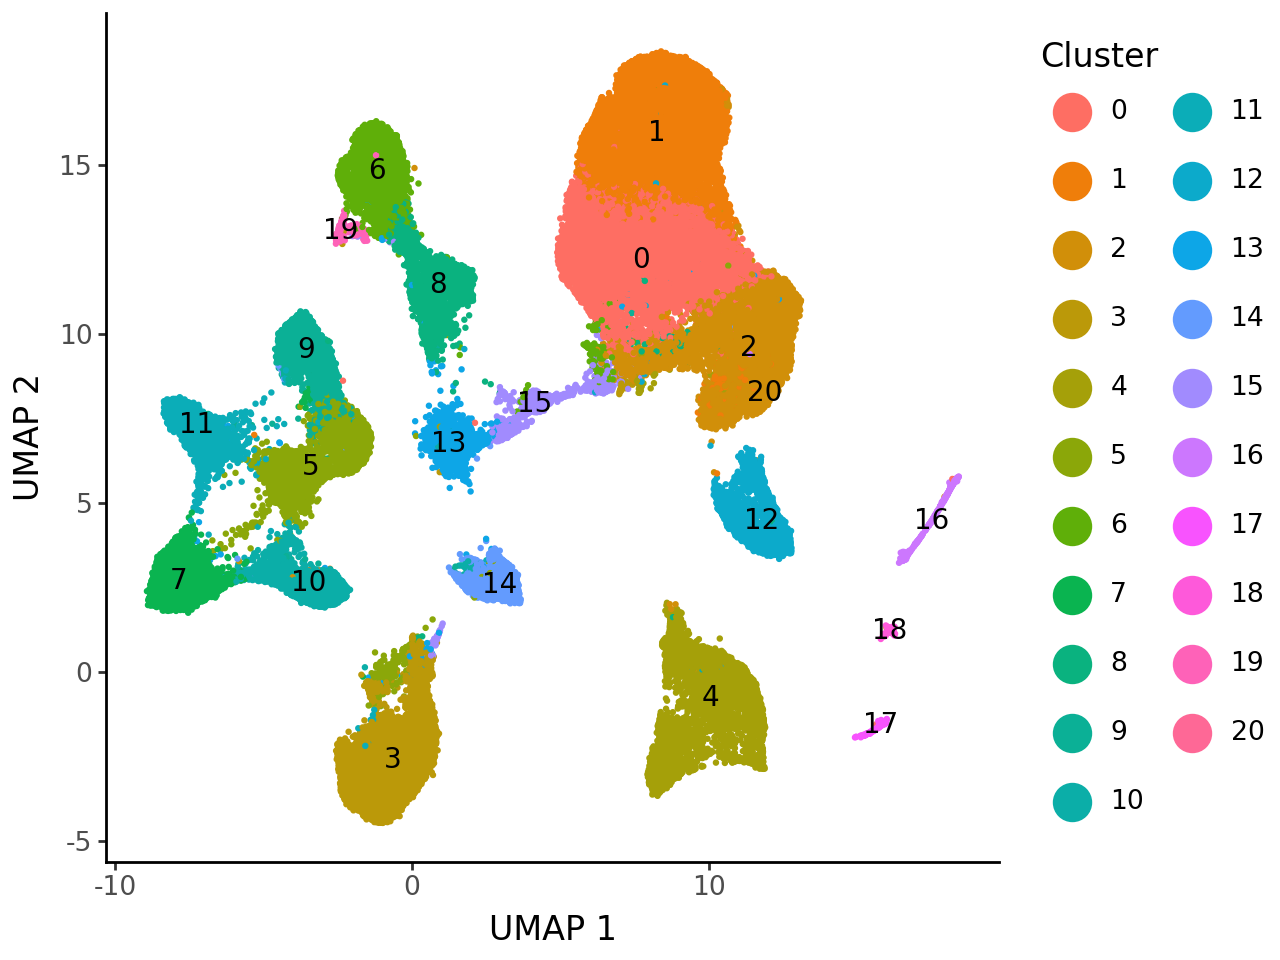

Performing Wilcoxon test on ALL datasets: Batch_1, Batch_2
CPU times: total: 38min 52s
Wall time: 16min 13s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [8]:
%%time

k=25
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [9]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.330079026077911
Batch Median LISI Scores: 1.1899234999938515
Celltype Mean LISI Scores: 1.119305972186592
Celltype Median LISI Scores: 1.0142139232036746
kBET score 20: 0.7970204360814093
kBET score 30: 0.7929660236187499
kBET score 40: 0.7904851475473911
ASW (CellType): 0.13514775037765503
ASW (Batch): 0.2641221582889557
Execution Time: 192.8861963748932 seconds


100%|██████████| 30/30 [17:26<00:00, 34.88s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


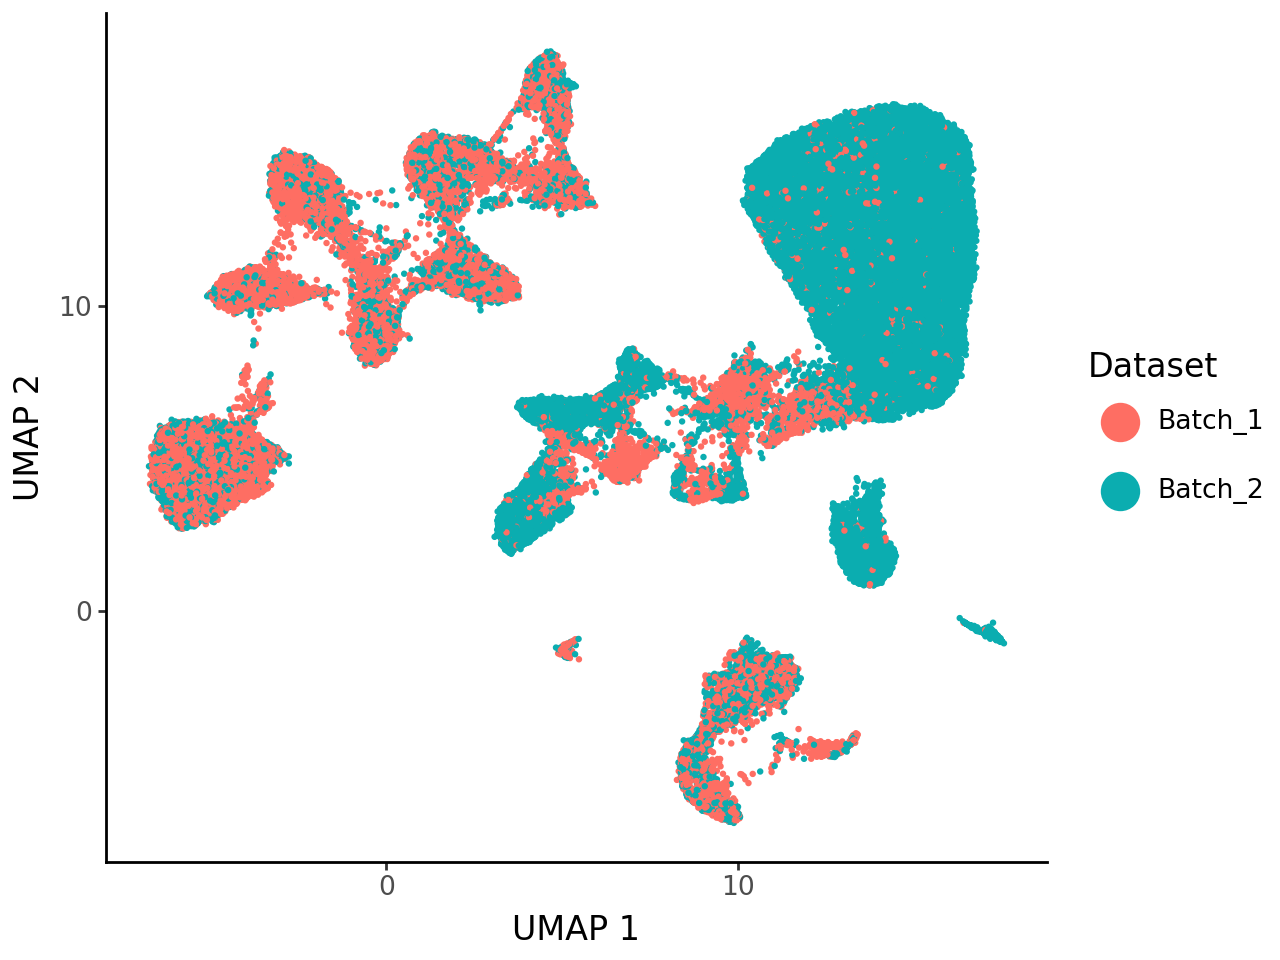

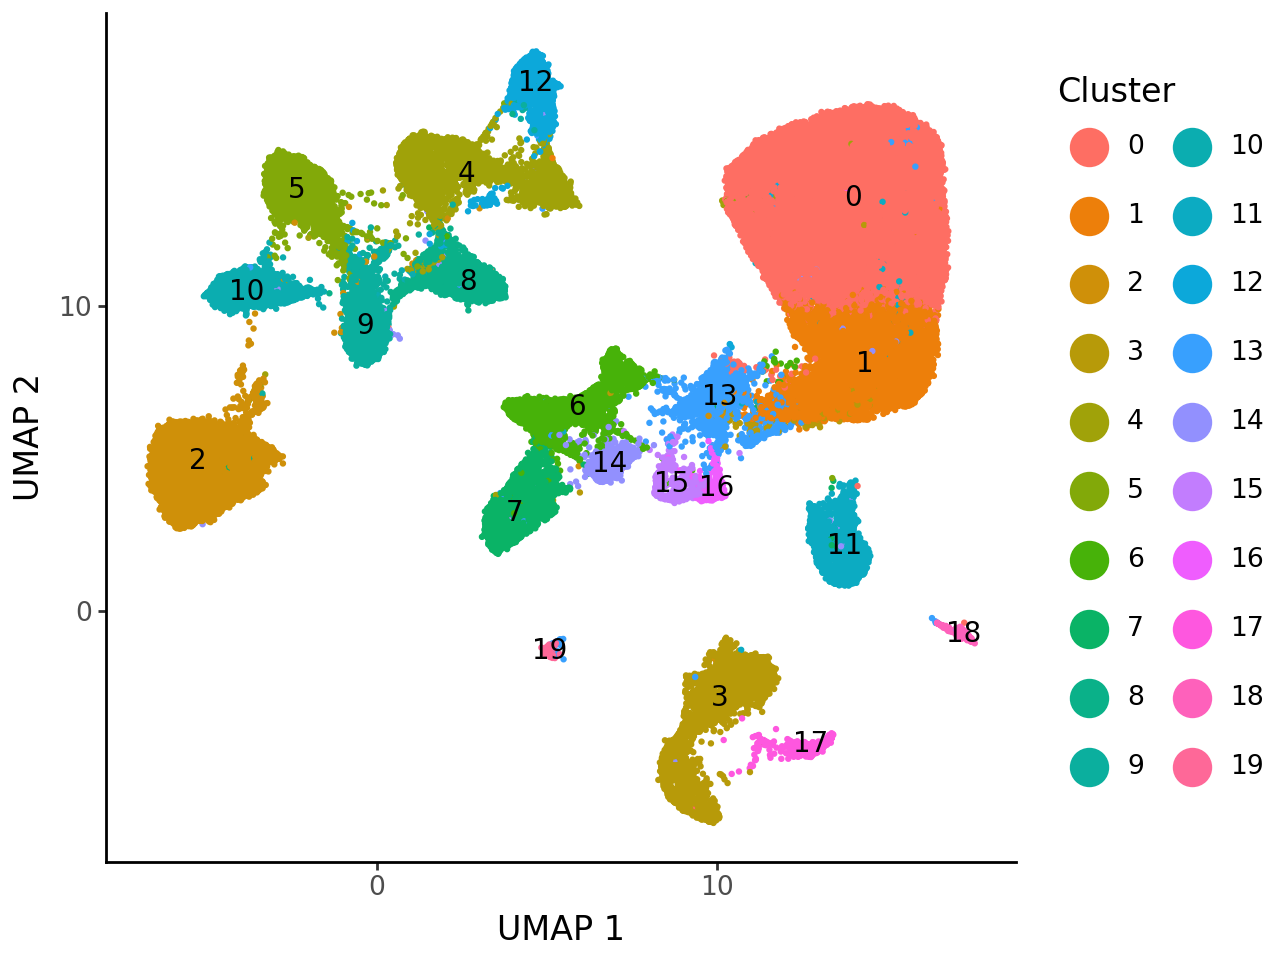

Performing Wilcoxon test on ALL datasets: Batch_1, Batch_2
CPU times: total: 31min 18s
Wall time: 25min 52s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [23]:
%%time

k=25
var_thresh=0.01

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [24]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 1.3390201588837
Batch Median LISI Scores: 1.2232652025850963
Celltype Mean LISI Scores: 1.120014607102265
Celltype Median LISI Scores: 1.0208883700846454
kBET score 20: 0.78859613612887
kBET score 30: 0.7843686311733996
kBET score 40: 0.7819090426868421
ASW (CellType): 0.22048501670360565
ASW (Batch): 0.23550184071063995
Execution Time: 299.9537320137024 seconds


In [ ]:
%%time

k=25
var_thresh=0.01

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

 73%|███████▎  | 22/30 [06:17<02:15, 16.94s/it]

In [26]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

KeyboardInterrupt: 

In [ ]:
%%time

k=20
var_thresh=0.01

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [ ]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

In [ ]:
%%time

k=20
var_thresh=0.2

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [ ]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

## HARMONY

In [31]:
%%time

# Check if batch_label exists in metadata
if batch_label not in metadata.columns:
    raise ValueError(f"'{batch_label}' not found in metadata columns.")

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    if not cell_names.is_unique:
        raise ValueError(f"Cell names are not unique in batch {batch}. Please ensure all cell names are unique.")
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    if not gene_names.is_unique:
        raise ValueError(f"Gene names are not unique in the expression matrix. Please ensure all gene names are unique.")
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    # Explicitly set names for obs and var indices
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    # Add the 'sample_name' key to uns (if not already there)
    adata.uns['sample_name'] = batch  # Assign the batch name as sample name
    
    # Check that indices are unique and populated
    if not adata.obs.index.is_unique:
        raise ValueError(f"Cell names are not unique in the AnnData object for batch {batch}.")
    
    if not adata.var.index.is_unique:
        raise ValueError(f"Gene names are not unique in the AnnData object for batch {batch}.")
    
    # Debugging output
    print(f"Batch: {batch}, Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
    
    # Verify that the AnnData object has both row (cell) and column (gene) names
    print(f"First 5 cell names: {adata.obs.index[:5]}")
    print(f"First 5 gene names: {adata.var.index[:5]}")
    
    adata_list.append(adata)

Batch: Batch_1, Number of cells: 26830, Number of genes: 12333
First 5 cell names: Index(['Bipolar1_CCCACAAGACTA', 'Bipolar1_CAAAGCATTTGC',
       'Bipolar1_CTTTTGATTGAC', 'Bipolar1_GCTCCAATGACA',
       'Bipolar1_AAATACCCTCAT'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610009O20Rik'],
      dtype='object', name='gene_names')
Batch: Batch_2, Number of cells: 44808, Number of genes: 12333
First 5 cell names: Index(['p1_AAAAAAACAGTC', 'p1_AAAAAAATGGTA', 'p1_AAAAACTCTTAG',
       'p1_AAAAAGTCGGCT', 'p1_AAAAATTTGTTC'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610009O20Rik'],
      dtype='object', name='gene_names')
CPU times: total: 812 ms
Wall time: 21.4 s


<timed exec>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


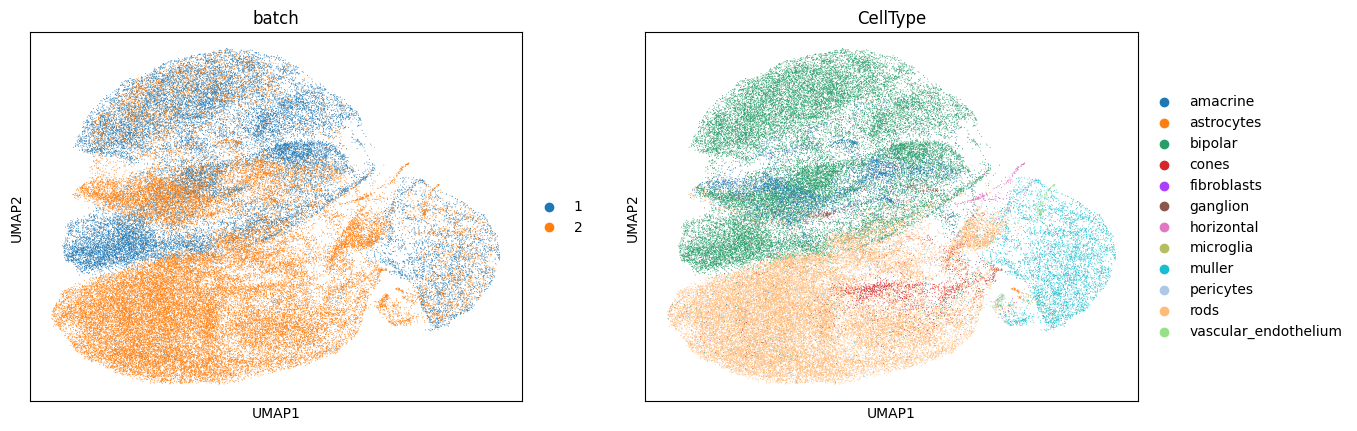

CPU times: total: 13min 35s
Wall time: 3min 13s


In [32]:
%%time

# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            # Cell metadata
    batch_key=batch_label          # Column name in `obs` for batch information
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(combined_adata)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'], save="_harmony_umap.png")

In [33]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

Batch Mean LISI Scores: 1.140573409430671
Batch Median LISI Scores: 1.0056470105157396
Celltype Mean LISI Scores: 1.129843128214504
Celltype Median LISI Scores: 1.0033585188052236
CPU times: total: 2min 39s
Wall time: 2min 44s


In [34]:
%%time

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.7082358524805272
CPU times: total: 7.56 s
Wall time: 7.87 s


In [35]:
%%time

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

ASW (CellType): -0.23706883192062378
ASW (Batch): 0.09389118105173111
CPU times: total: 3min 36s
Wall time: 2min 48s


## Pycombat

In [3]:
# Downcast numeric columns
expr_mat = expr_mat.apply(pd.to_numeric, downcast='float')
expr_mat = expr_mat.apply(pd.to_numeric, downcast='integer')
print("Optimized memory usage:", expr_mat.memory_usage(deep=True).sum() / 1e9, "GB")

Optimized memory usage: 0.90104549 GB


In [4]:
# Convert dense DataFrame to Sparse
expr_mat = expr_mat.astype(pd.SparseDtype("float", fill_value=0))
print("Memory usage after sparsity optimization:", expr_mat.memory_usage(deep=True).sum() / 1e9, "GB")

Memory usage after sparsity optimization: 0.649943165 GB


In [5]:
%%time

# Step 1: Generate the batch list
batch_label = 'batch'
celltype_label = 'CellType'
datasets = []
batch = []
mod = []

for batch_index, batch_value in enumerate(metadata[batch_label].unique()):
    batch_cells = metadata[metadata[batch_label] == batch_value].index
    datasets.append(expr_mat.loc[:, batch_cells])
    batch.extend([batch_index] * len(batch_cells))
    
    # Add the corresponding cell types for the batch cells
    celltypes_for_batch = metadata.loc[batch_cells, celltype_label].values
    mod.extend(celltypes_for_batch)  # Collect cell type information as a covariate

# Concatenate all datasets by keeping only the common genes (inner join)
df_expression = pd.concat(datasets, axis=1, join="inner")

df_corrected = pycombat(df_expression, batch)

# Step 2: Apply pycombat with cell type as a covariate
# df_corrected = pycombat(df_expression, batch, mod=mod, precision=0.001)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
CPU times: total: 6min 14s
Wall time: 9min 37s


In [6]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.
    
    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array or pd.Series, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.
    
    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Transpose the data if needed
    if embedding.shape[0] != len(labels):
        embedding = embedding.T
    
    # Ensure labels is a pandas Series
    if not isinstance(labels, pd.Series):
        labels = pd.Series(labels)
    
    # Validate input shapes
    if len(labels) != embedding.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embedding.shape[0]})")
    
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 to exclude self
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Exclude self from neighbors
        cell_neighbors = cell_neighbors[1:]
        
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels.iloc[cell_neighbors]
        
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels.iloc[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time

# Assuming df_corrected is your corrected data matrix (cells x genes)
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(df_corrected.T)  # Transpose if needed (cells x genes -> genes x cells)

# Calculate kBET score
kbet_score = calculate_kbet(embedding, batch)
print(f"kBET Score: {kbet_score}")

# Convert to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

# Ensure that the 'batch' and 'CellType' are in the metadata and aligned with embedding_df
embedding_df['batch'] = metadata['batch']
embedding_df['CellType'] = metadata['CellType']

# Example call to compute LISI for both batch and cell type
label_colnames = ["batch", "CellType"]  # Modify as per your metadata
lisi_scores = compute_lisi(
    X=embedding_df[['UMAP1', 'UMAP2']],  # Using the embedding columns
    metadata=embedding_df,  # DataFrame with batch/celltype information
    label_colnames=label_colnames,
    perplexity=30           # Adjust perplexity based on dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

# ASW Calculation Function
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    # Extract embeddings
    embeddings = data[embeddings_columns].values
    
    # Validate labels
    labels = data[labels_column]  # Directly access the labels from the DataFrame
    
    # Check if lengths match
    if len(labels) != embeddings.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embeddings.shape[0]})")
    
    # Calculate silhouette score (ASW)
    asw_score = silhouette_score(embeddings, labels)
    return asw_score

# Calculate ASW for both "batch" and "CellType"
batch_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'batch')
celltype_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'CellType')

# Print ASW scores
print(f"Batch ASW Score: {batch_asw}")
print(f"Celltype ASW Score: {celltype_asw}")

kBET Score: 0.8012151372176778
Batch Mean LISI Scores: 1.3241637887979478
Batch Median LISI Scores: 1.1536265532495595
Celltype Mean LISI Scores: 1.4563957191446535
Celltype Median LISI Scores: 1.282943619115723
Batch ASW Score: 0.013805529102683067
Celltype ASW Score: -0.10702797770500183
CPU times: total: 1h 50min 46s
Wall time: 15min 30s


: 